In [1]:
from typing import Any, Tuple, Mapping, Callable, List, Dict
from functools import partial
from flax.metrics import tensorboard
import orbax
import orbax.checkpoint
import flax.jax_utils
from flaxdiff.models.simple_unet import Unet
import jax.experimental.pallas.ops.tpu.flash_attention
from flaxdiff.predictors import VPredictionTransform, EpsilonPredictionTransform, DiffusionPredictionTransform, DirectPredictionTransform, KarrasPredictionTransform
from flaxdiff.schedulers import CosineNoiseSchedule, NoiseScheduler, GeneralizedNoiseScheduler, KarrasVENoiseScheduler, EDMNoiseScheduler
import struct as st
import flax
import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import grain.python as pygrain
import numpy as np
import augmax

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools

import json
# For CLIP
from transformers import AutoTokenizer, FlaxCLIPTextModel, CLIPTextModel
import wandb
import cv2
import argparse

import resource

from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import mesh_utils
from jax.experimental.shard_map import shard_map

2024-08-07 13:28:03.755310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 13:28:03.778252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 13:28:03.785018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 13:28:04.718287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mrwhite0racle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tq

In [2]:
!pip install -U flaxdiff

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 KB 2.0 MB/s eta 0:00:00
  Attempting uninstall: flaxdiff
    Found existing installation: flaxdiff 0.1.4
    Uninstalling flaxdiff-0.1.4:
      Successfully uninstalled flaxdiff-0.1.4


In [2]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

In [3]:
from flaxdiff.trainer import DiffusionTrainer
from flaxdiff.utils import RandomMarkovState, MarkovState
from flaxdiff.models.simple_unet import Unet

In [83]:
CONFIG = {
    #   "dtype": "bfloat16",
    #   "precision": "high",
    #   "activation": "swish",
      "emb_features": 256,
      "feature_depths": [
        64,
        128,
        256,
        512,
        # 512
      ],
      "num_res_blocks": 3,
      "output_channels": 3,
      "attention_configs": [
        None,
        {
          "dtype": jnp.bfloat16,
          "heads": 16,
          "use_projection": False,
          "flash_attention": False,
          "use_self_and_cross": False
        },
        {
          "dtype": jnp.bfloat16,
          "heads": 16,
          "use_projection": False,
          "flash_attention": False,
          "use_self_and_cross": False
        },
        {
          "dtype": jnp.bfloat16,
          "heads": 16,
          "use_projection": False,
          "flash_attention": False,
          "use_self_and_cross": False
        }
      ],
      "num_middle_res_blocks": 1
}

In [5]:
from flaxdiff.models.autoencoder.diffusers import StableDiffusionVAE
autoencoder = StableDiffusionVAE()


Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 88534.12it/s]
/home/mrwhite0racle/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /home/mrwhite0racle/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_care_embeds_weights',), ('vision_model', 'vision_model', 'embeddings', 'class_embedding'), ('vision_model', 'vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'vision_model', 'embeddings', 'position_embedding', 'embedding'), ('vision_model', 'vision_model', 'encoder

In [91]:
# checkpoint_id = "dataset_laiona_coco/image_size_256/batch_256_v4_32_flaxdiff_0_1_6_ldm"
# checkpoint_id = "dataset-laiona_coco/image_size-128/batch-512-v4-64"
checkpoint_id = "dataset-aesthetic_coyo/image_size-128/batch-64-v4-16"

model_config = CONFIG
IMAGE_SIZE=128
DIFFUSION_INPUT_SIZE = IMAGE_SIZE

if "ldm" in checkpoint_id:
    DIFFUSION_INPUT_SIZE = IMAGE_SIZE // 8
    model_config['output_channels'] = 4

unet = Unet(activation=jax.nn.swish, dtype=jnp.bfloat16, precision=jax.lax.Precision.HIGH, **model_config)
solver = optax.adam(2e-4)


edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
karas_ve_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=edm_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=checkpoint_id,
                           model_output_transform=KarrasPredictionTransform(sigma_data=edm_schedule.sigma_data),
                           input_shapes= {
                                "x": (DIFFUSION_INPUT_SIZE, DIFFUSION_INPUT_SIZE, model_config['output_channels']),
                                "temb": (),
                                "textcontext": (77, 768)
                            },
                        #    train_state=trainer.best_state,
                        #    loss_fn=lambda x, y: jnp.abs(x - y),
                            # param_transforms=params_transform,
                           load_from_checkpoint=True,
                           checkpoint_id=checkpoint_id.replace(' ', '_').replace('-', '_').lower(),
                           checkpoint_base_path="gs://flaxdiff-datasets-regional/checkpoints/",
                        #    autoencoder=autoencoder
                           )

Loading model from checkpoint 1
Loaded model from checkpoint at epoch 1 0.055114582
Generating states for DiffusionTrainer


In [80]:
from flaxdiff.utils import clip_images

def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)
    
class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 guidance_scale:float = 0.0,
                 null_labels_seq:jax.Array=None,
                 autoencoder=None,
                 image_size=IMAGE_SIZE,
                 autoenc_scale_reduction=8,
                 autoenc_latent_channels=4,
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform
        self.guidance_scale = guidance_scale
        self.image_size = image_size
        self.autoenc_scale_reduction = autoenc_scale_reduction
        self.autoencoder = autoencoder
        self.autoenc_latent_channels = autoenc_latent_channels
        
        if self.guidance_scale > 0:
            # Classifier free guidance
            assert null_labels_seq is not None, "Null labels sequence is required for classifier-free guidance"
            print("Using classifier-free guidance")
            @jax.jit
            def sample_model(x_t, t, *additional_inputs):
                # Concatenate unconditional and conditional inputs
                x_t_cat = jnp.concatenate([x_t] * 2, axis=0)
                t_cat = jnp.concatenate([t] * 2, axis=0)
                rates_cat = self.noise_schedule.get_rates(t_cat)
                c_in_cat = self.model_output_transform.get_input_scale(rates_cat)
                
                text_labels_seq, = additional_inputs
                text_labels_seq = jnp.concatenate([text_labels_seq, jnp.broadcast_to(null_labels_seq, text_labels_seq.shape)], axis=0)
                model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t_cat * c_in_cat, t_cat), text_labels_seq)
                # Split model output into unconditional and conditional parts
                model_output_cond, model_output_uncond = jnp.split(model_output, 2, axis=0)
                model_output = model_output_uncond + guidance_scale * (model_output_cond - model_output_uncond)
                
                x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
                return x_0, eps, model_output
            
            self.sample_model = sample_model
        else:
            # Unconditional sampling
            @jax.jit
            def sample_model(x_t, t, *additional_inputs):
                rates = self.noise_schedule.get_rates(t)
                c_in = self.model_output_transform.get_input_scale(rates)
                model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t), *additional_inputs)
                x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
                return x_0, eps, model_output
            
            self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, model_conditioning_inputs, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step, *model_conditioning_inputs)
        # plotImages(pred_images)
        pred_images = clip_images(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state,
                             model_conditioning_inputs=model_conditioning_inputs
                             )
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        image_size = self.image_size
        image_channels = 3
        if self.autoencoder is not None:
            image_size = image_size // self.autoenc_scale_reduction
            image_channels = self.autoenc_latent_channels
        return jax.random.normal(rngs, (num_images, image_size, image_size, image_channels)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42)),
                        model_conditioning_inputs:tuple=()
                        ) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        # @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              model_conditioning_inputs=model_conditioning_inputs,
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones, *model_conditioning_inputs)
        if self.autoencoder is not None:
            samples = self.autoencoder.decode(samples)
        samples = clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        mean = self.noise_schedule.get_posterior_mean(reconstructed_samples, current_samples, current_step)
        variance = self.noise_schedule.get_posterior_variance(steps=current_step)
        
        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        return mean + noise * variance, state
    
    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)
    
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

class DDIMSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state
    
class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state

class SimplifiedEulerSampler(DiffusionSampler):
    """
    This is for networks with forward diffusion of the form x_{t+1} = x_t + sigma_t * epsilon_t
    """
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        dx = (current_samples - reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state
    
class HeunSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        estimated_x_0, _, _ = self.sample_model(next_samples_0, next_step, *model_conditioning_inputs)
        
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

class RK4Sampler(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        @jax.jit
        def get_derivative(x_t, sigma, state:RandomMarkovState, model_conditioning_inputs) -> tuple[jnp.ndarray, RandomMarkovState]:
            t = self.noise_schedule.get_timesteps(sigma)
            x_0, eps, _ = self.sample_model(x_t, t, *model_conditioning_inputs)
            return eps, state
        
        self.get_derivative = get_derivative

    def sample_step(self, current_samples:jnp.ndarray, current_step, model_conditioning_inputs, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        k1, state = self.get_derivative(current_samples, current_sigma, state, model_conditioning_inputs)
        k2, state = self.get_derivative(current_samples + 0.5 * k1 * dt, current_sigma + 0.5 * dt, state, model_conditioning_inputs)
        k3, state = self.get_derivative(current_samples + 0.5 * k2 * dt, current_sigma + 0.5 * dt, state, model_conditioning_inputs)
        k4, state = self.get_derivative(current_samples + k3 * dt, current_sigma + dt, state, model_conditioning_inputs)

        next_samples = current_samples + (((k1 + 2 * k2 + 2 * k3 + k4) * dt) / 6)
        return next_samples, state

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = []

    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    
class EulerAncestralSampler(DiffusionSampler):
    def take_next_step(self, current_samples, reconstructed_samples, model_conditioning_inputs,
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        sigma_up = (next_sigma**2 * (current_sigma**2 - next_sigma**2) / current_sigma**2) ** 0.5
        sigma_down = (next_sigma**2 - sigma_up**2) ** 0.5
        
        dt = sigma_down - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (next_sigma - current_sigma)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        
        state, subkey = state.get_random_key()
        dW = jax.random.normal(subkey, current_samples.shape) * sigma_up
        
        next_samples = current_samples + dx * dt + dW
        return next_samples, state

In [13]:
def defaultTextEncodeModel():
    modelname = "openai/clip-vit-large-patch14"
    model = FlaxCLIPTextModel.from_pretrained(modelname, dtype=jnp.float16)
    tokenizer = AutoTokenizer.from_pretrained(modelname, dtype=jnp.float16)
    return model, tokenizer

def encodePrompts(prompts, model, tokenizer=None):
    if model == None:
        model, tokenizer = defaultTextEncodeModel()
    if tokenizer == None:
        tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")

    # inputs = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="np")
    inputs = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="np")

    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    pooler_output = outputs.pooler_output  # pooled (EOS token) states
    embed_pooled = pooler_output.astype(jnp.float16)
    embed_labels_full = last_hidden_state.astype(jnp.float16)
    
    return embed_pooled, embed_labels_full

textEncoderModel, textTokenizer = defaultTextEncodeModel()

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '10', 'self_attn', 'v_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '19', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '23', 'mlp', 'fc1', 'kernel'), ('vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'encoder', 'layers', '2', 'layer_norm2', 'scale'), ('vision_model', 'encoder', 'layers', '15', 'self_attn', 'v_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '17', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '10', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '19', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '23', 'mlp', 'fc1', 'bias'), ('vision_model', 'pre_layrnorm', 'bias'), ('vision_model', 'encoder', 'layers', '

In [14]:
null_labels, null_labels_full = encodePrompts([""], textEncoderModel, textTokenizer)

Using classifier-free guidance


100%|██████████| 200/200 [00:54<00:00,  3.64it/s]


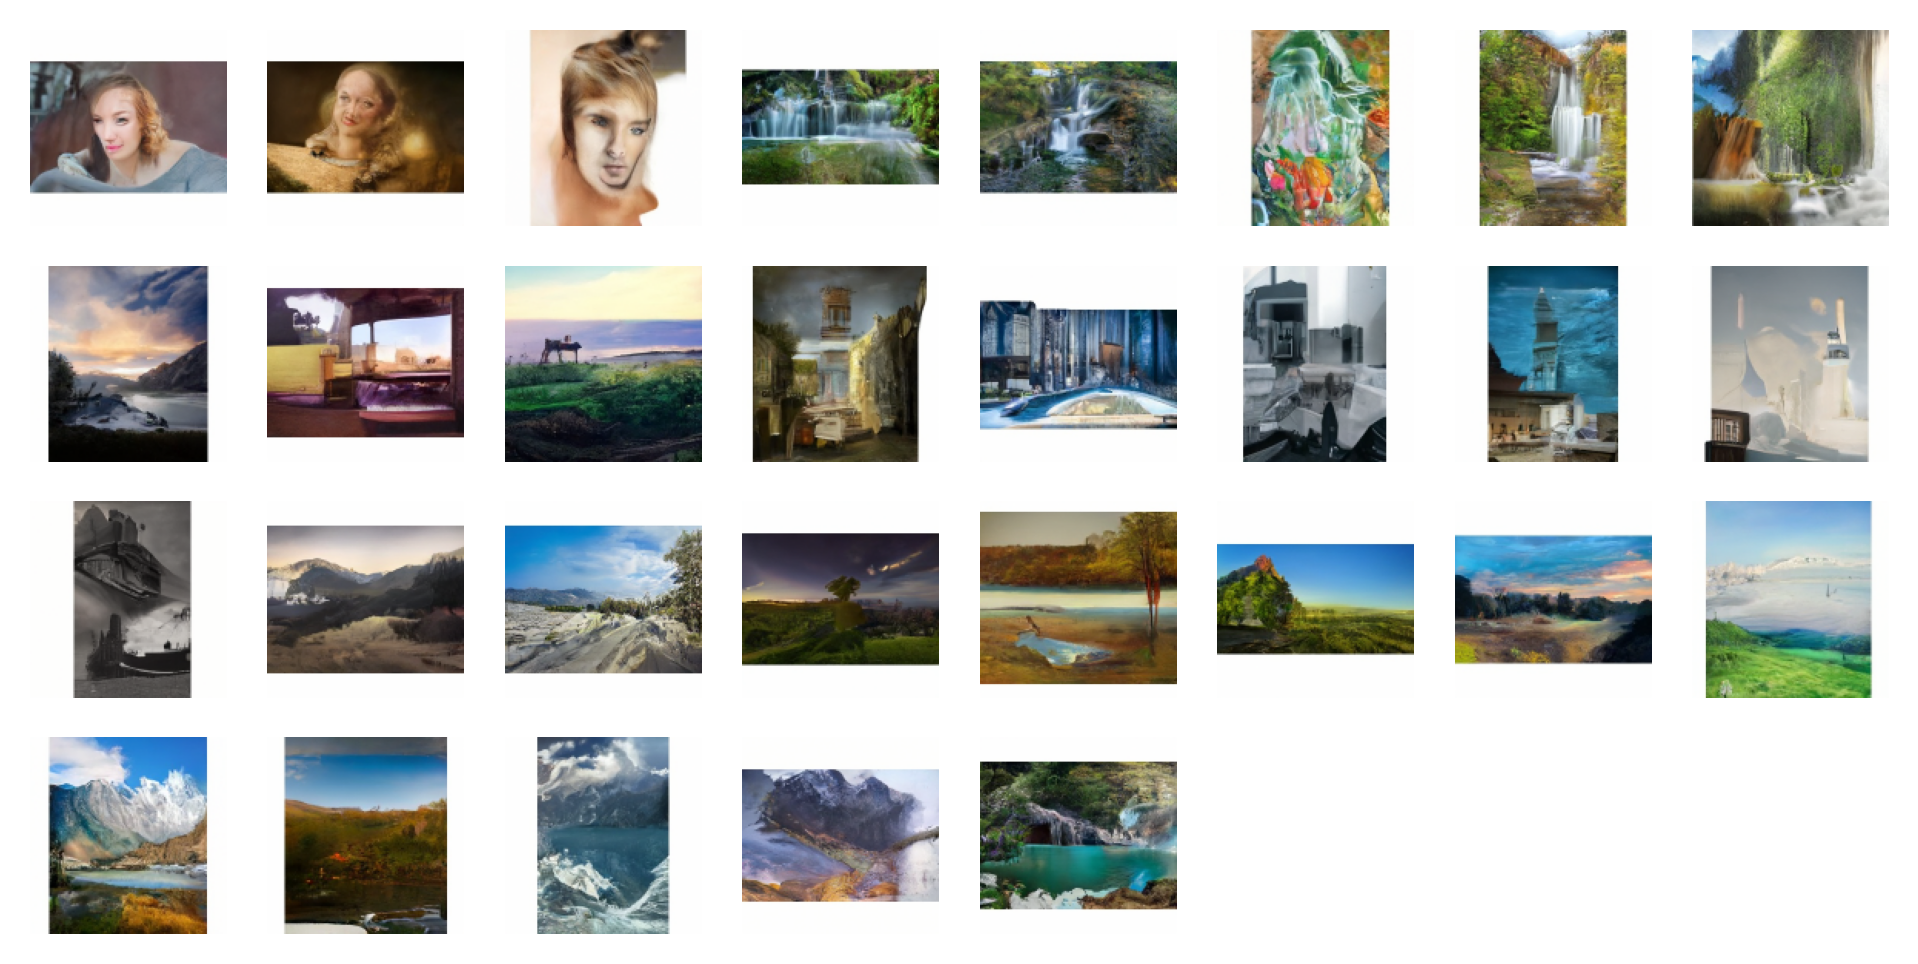

In [27]:

prompts = [
    "A photo of a beautiful young girl",
    "A photo of a beautiful young girl",
    "A photo of a beautiful young girl",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "A beautiful waterfall",
    "a big house",
    "a big house",
    "a big house",
    "a big house",
    "a big house",
    "a big building",
    "a big building",
    "a big building",
    "a big building",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    "a beautiful river with a mountain",
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.get_state().ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform, guidance_scale=2, null_labels_seq=null_labels_full)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=300)


Using classifier-free guidance


100%|██████████| 200/200 [00:24<00:00,  8.17it/s]


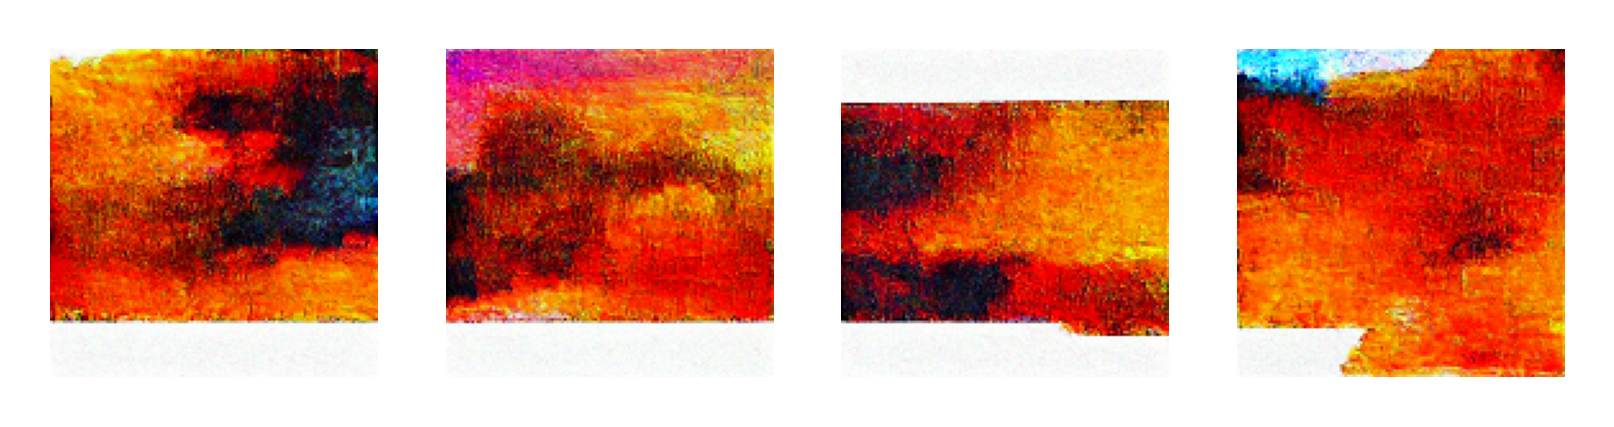

In [92]:

prompts = [
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful landscape",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    # "a beautiful river with a mountain",
    ]
pooled_labels, labels_seq = encodePrompts(prompts, textEncoderModel, textTokenizer)

sampler = EulerAncestralSampler(trainer.model, trainer.get_best_state().ema_params, karas_ve_schedule, autoencoder=trainer.autoencoder, 
                                model_output_transform=trainer.model_output_transform, guidance_scale=2, null_labels_seq=null_labels_full)
samples = sampler.generate_images(num_images=len(prompts), diffusion_steps=200, start_step=1000, end_step=0, priors=None, model_conditioning_inputs=(labels_seq,))
plotImages(samples, dpi=500)


In [95]:
def data_source_tfds(name, use_tf=True, split="all"):
    import tensorflow_datasets as tfds
    if use_tf:
        def data_source(path_override):
            return tfds.load(name, split=split, shuffle_files=True)
    else:
        def data_source(path_override):
            return tfds.data_source(name, split=split, try_gcs=False)
    return data_source

def tfds_augmenters(image_scale, method):
    class augmenters(pygrain.MapTransform):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def map(self, element) -> Dict[str, jnp.array]:
            image = element['image']
            image = cv2.resize(image, (image_scale, image_scale),
                            interpolation=cv2.INTER_AREA)
            return {
                "image": image,
            }
    return augmenters

def data_source_gcs(source='arrayrecord/laion-aesthetics-12m+mscoco-2017'):
    def data_source(base="/home/mrwhite0racle/gcs_mount"):
        records_path = os.path.join(base, source)
        records = [os.path.join(records_path, i) for i in os.listdir(
            records_path) if 'array_record' in i]
        ds = pygrain.ArrayRecordDataSource(records)
        return ds
    return data_source

def labelizer_gcs(sample):
    return sample['txt']

def unpack_dict_of_byte_arrays(packed_data):
    unpacked_dict = {}
    offset = 0
    while offset < len(packed_data):
        # Unpack the key length
        key_length = st.unpack_from('I', packed_data, offset)[0]
        offset += st.calcsize('I')
        # Unpack the key bytes and convert to string
        key = packed_data[offset:offset+key_length].decode('utf-8')
        offset += key_length
        # Unpack the byte array length
        byte_array_length = st.unpack_from('I', packed_data, offset)[0]
        offset += st.calcsize('I')
        # Unpack the byte array
        byte_array = packed_data[offset:offset+byte_array_length]
        offset += byte_array_length
        unpacked_dict[key] = byte_array
    return unpacked_dict

def gcs_augmenters(image_scale, method):
    labelizer = labelizer_gcs
    class augmenters(pygrain.MapTransform):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def map(self, element) -> Dict[str, jnp.array]:
            element = unpack_dict_of_byte_arrays(element)
            image = np.asarray(bytearray(element['jpg']), dtype="uint8")
            image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (image_scale, image_scale),
                            interpolation=cv2.INTER_AREA)
            return {
                "image": image,
            }
    return augmenters

# Configure the following for your datasets
datasetMap = {
    "oxford_flowers102": {
        "source": data_source_tfds("oxford_flowers102", use_tf=False),
        "augmenter": tfds_augmenters,
    },
    "cc12m": {
        "source": data_source_gcs('arrayrecord/cc12m'),
        "augmenter": gcs_augmenters,
    },
    "laiona_coco": {
        "source": data_source_gcs('arrayrecord/laion-aesthetics-12m+mscoco-2017'),
        "augmenter": gcs_augmenters,
    },
    "aesthetic_coyo": {
        "source": data_source_gcs('arrayrecords/aestheticCoyo_0.25clip_6aesthetic'),
        "augmenter": gcs_augmenters,
    },
}


def get_dataset_grain(
    data_name="cc12m",
    batch_size=64,
    image_scale=256,
    count=None,
    num_epochs=None,
    method=jax.image.ResizeMethod.LANCZOS3,
    grain_worker_count=32,
    grain_read_thread_count=64,
    grain_read_buffer_size=50,
    grain_worker_buffer_size=20,
    seed=0,
    dataset_source="/mnt/gcs_mount/",
):
    dataset = datasetMap[data_name]
    data_source = dataset["source"](dataset_source)
    augmenter = dataset["augmenter"](image_scale, method)

    local_batch_size = batch_size // jax.process_count()

    sampler = pygrain.IndexSampler(
        num_records=len(data_source) if count is None else count,
        shuffle=True,
        seed=seed,
        num_epochs=num_epochs,
        shard_options=pygrain.ShardByJaxProcess(),
    )

    transformations = [
        augmenter(),
        pygrain.Batch(local_batch_size, drop_remainder=True),
    ]

    loader = pygrain.DataLoader(
        data_source=data_source,
        sampler=sampler,
        operations=transformations,
        worker_count=grain_worker_count,
        read_options=pygrain.ReadOptions(
            grain_read_thread_count, grain_read_buffer_size
        ),
        worker_buffer_size=grain_worker_buffer_size,
    )

    def get_trainset():
        return loader

    return {
        "train": get_trainset,
        "train_len": len(data_source),
        "local_batch_size": local_batch_size,
        "global_batch_size": batch_size,
    }

In [108]:
dataset = get_dataset_grain("aesthetic_coyo", batch_size=16, image_scale=512, dataset_source="/home/mrwhite0racle/gcs_mount/")

In [109]:
sample_data = next(iter(dataset['train']()))['image']
sample_data = (sample_data - 127.5) / 127.5

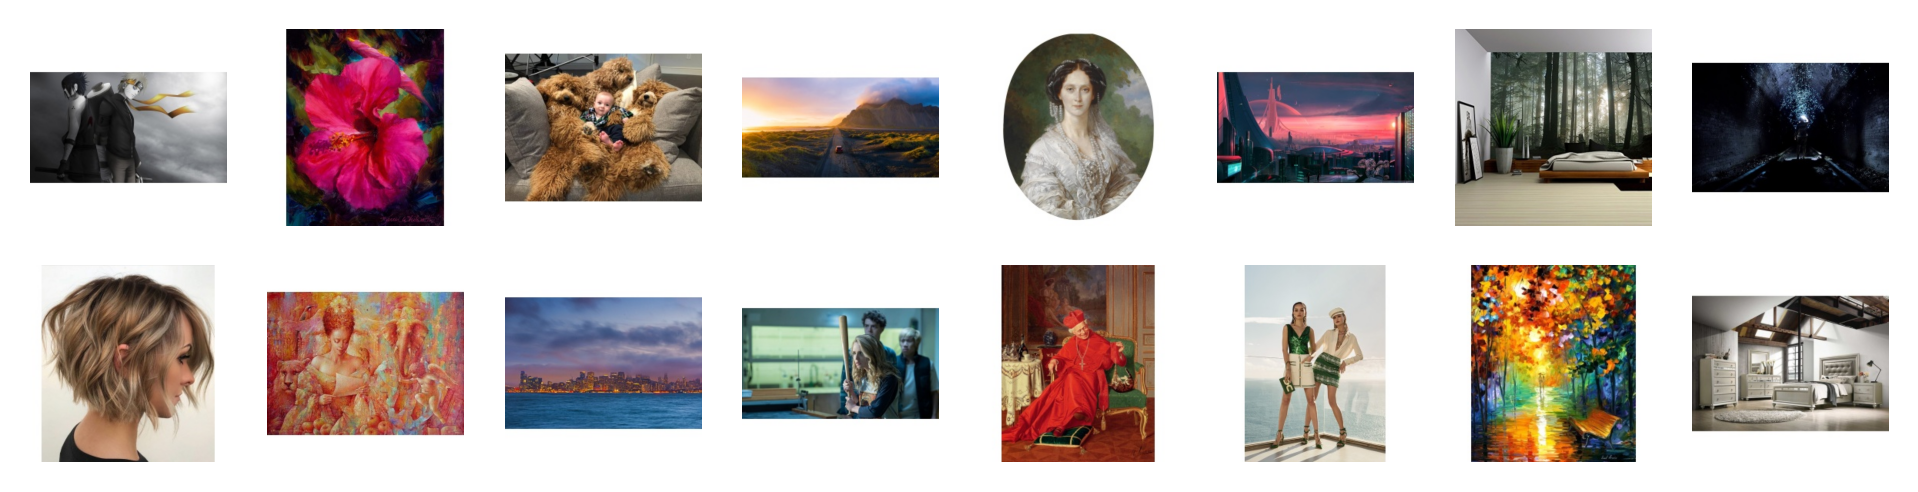

In [110]:
plotImages(sample_data, dpi=300)

In [111]:
latents = autoencoder.encode(sample_data)

In [ ]:
recons = autoencoder.decode(latents)
recons = jnp.clip(recons, -1, 1) 

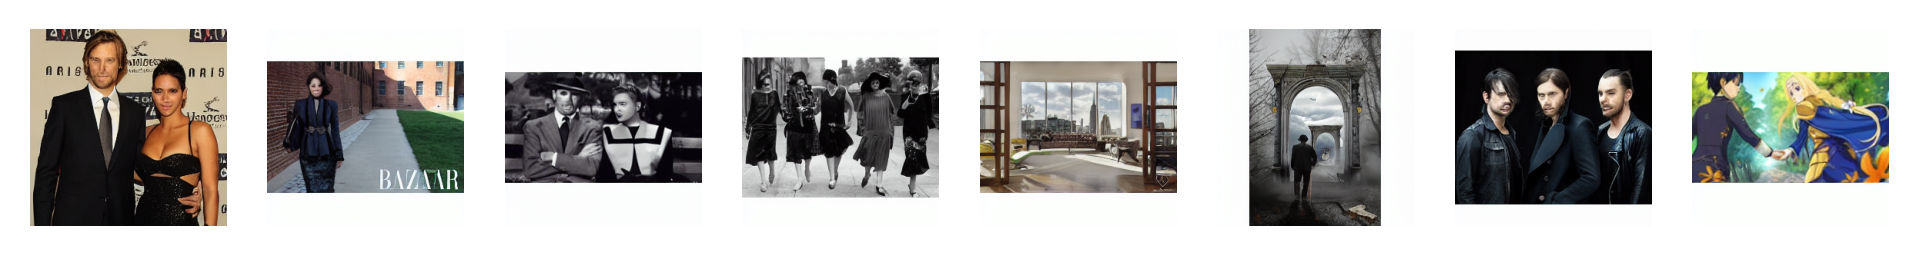

In [ ]:
plotImages(recons, dpi=300)